In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
from matplotlib import gridspec
import os
import pickle
import itertools
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
snow = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])
CS2_CPOM = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_CPOM_full.nc')['Radar Freeboard'])
CS2_LARM = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_LARM_full.nc')['Radar Freeboard'])
CS2S3_CPOM = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2S3_CPOM_full.nc')['Radar Freeboard'])
CS2S3_LARM = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2S3_LARM_full.nc')['Radar Freeboard'])

### calculate correlations

In [3]:
# do smooth anoms for each grid cell

T1 = 15 ## for 31-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

sets = [CS2_CPOM, CS2_LARM, CS2S3_CPOM, CS2S3_LARM, snow]
sats = ['CS2_CPOM','CS2_LARM','CS2S3_CPOM','CS2S3_LARM','snow']
all_running_mean_anoms = {}

for s, sat in zip(sets, sats):
    
    anoms_big = np.full(s.shape,np.nan)

    for day in tqdm.trange(s.shape[0]):

        mean_31day = np.nanmean(s[day-T1:day+T1],axis=0) # each day, make the 30 day running mean (15 either side)

        anoms_big[day] = s[day] - mean_31day # now make anomalies from 30 day means

    running_mean_anoms = np.full(s.shape,np.nan)

    for day in tqdm.trange(s.shape[0]):
        running_mean_anoms[day] = np.nanmean(anoms_big[day-T2:day+T2],axis=0) # 9 day mean of anoms for each grid cell in time dimension
        
    all_running_mean_anoms[sat] = running_mean_anoms

100%|██████████████████████████████████████| 4018/4018 [00:14<00:00, 275.44it/s]


In [4]:
# stats for CS2 full 2010-2020 period
sats = ['CS2_CPOM_full','CS2_LARM_full']
dics = [all_running_mean_anoms['CS2_CPOM'],all_running_mean_anoms['CS2_LARM']]

all_ps = {}
all_rs = {}

for sat, dic in zip(sats,dics):
    ps = np.full((snow.shape[1],snow.shape[2]), np.nan)
    rs = np.full((snow.shape[1],snow.shape[2]), np.nan)

    for i, j in tqdm.tqdm(itertools.product(np.arange(snow.shape[1]),
                                  np.arange(snow.shape[2]))):
        
        # calculate p and r for full timeseries per grid cell

        mask = ~np.isnan(all_running_mean_anoms['snow'][:,i,j]) & ~np.isnan(dic[:,i,j]) # mask out cells with nan snow or nan freeb

        if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue

            rstats = linregress(all_running_mean_anoms['snow'][:,i,j][mask],dic[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
            r = rstats.rvalue
            p = rstats.pvalue
            ps[i,j] = p
            rs[i,j] = r
 
    all_ps[sat] = ps
    all_rs[sat] = rs

129600it [00:12, 10618.39it/s]
129600it [00:12, 10401.02it/s]


In [5]:
# stats for 2019-2020 only
sats = ['CS2_CPOM','CS2_LARM','CS2S3_CPOM','CS2S3_LARM']

for sat in sats:
    
    fb = all_running_mean_anoms[sat][3560:3773]
    snow = all_running_mean_anoms['snow'][3560:3773]

    ps = np.full((snow.shape[1],snow.shape[2]), np.nan)
    rs = np.full((snow.shape[1],snow.shape[2]), np.nan)

    for i, j in tqdm.tqdm(itertools.product(np.arange(snow.shape[1]),
                                  np.arange(snow.shape[2]))):
        
        # calculate p and r for full timeseries per grid cell

        mask = ~np.isnan(snow[:,i,j]) & ~np.isnan(fb[:,i,j]) # mask out cells with nan snow or nan freeb

        if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue

            rstats = linregress(snow[:,i,j][mask],fb[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
            r = rstats.rvalue
            p = rstats.pvalue
            ps[i,j] = p
            rs[i,j] = r

    all_ps[sat] = ps
    all_rs[sat] = rs

129600it [00:02, 45598.80it/s]
129600it [00:02, 48337.83it/s]
129600it [00:02, 47232.57it/s]
129600it [00:02, 47150.30it/s]


In [6]:
CS2_diff = np.abs(np.asarray(all_rs['CS2_CPOM_full'])) - np.abs(np.asarray(all_rs['CS2_LARM_full']))
all_rs['CS2_CPOM_full - CS2_LARM_full'] = CS2_diff
CS2_diff = np.abs(np.asarray(all_rs['CS2_CPOM'])) - np.abs(np.asarray(all_rs['CS2_LARM']))
all_rs['CS2_CPOM - CS2_LARM'] = CS2_diff
CS2S3_diff = np.abs(np.asarray(all_rs['CS2S3_CPOM'])) - np.abs(np.asarray(all_rs['CS2S3_LARM']))
all_rs['CS2S3_CPOM - CS2S3_LARM'] = CS2S3_diff

### plot figure

In [7]:
days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]
dayss = [np.arange(273,485), # 2010-2011
        np.arange(638,851), # 2011-2012
        np.arange(1004,1216), # 2012-2013
        np.arange(1369,1581), # 2013-2014
        np.arange(1734,1946), # 2014-2015
        np.arange(2099,2312), # 2015-2016
        np.arange(2465,2677), # 2016-2017
        np.arange(2830,3042), # 2017-2018
        np.arange(3195,3407), # 2018-2019
        np.arange(3560,3773), # 2019-2020
       ]

### create MYI area line
all_MYI = []
datapath = '/Users/carmennab/Dropbox/OI_PolarSnow/data/CDS_icetype/'

all_MYI = np.full((len(days),432, 432),np.nan)

for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    try:
        icetype = Dataset(datapath+'ice_type_nh_ease2-250_cdr-v2p0_'+str(date)+'1200.nc')
        ice_type = np.asarray(icetype['ice_type'][0])
        ice_type[ice_type>3]=0
        ice_type[ice_type<3]=0 
        ice_type[ice_type==3]=1
        all_MYI[day] = ice_type
    except:
        pass
    
MYI_days = (all_MYI == 1).sum(axis = 0).astype(np.float32)    
icetype_lon = np.array(icetype['lon'])
icetype_lat = np.array(icetype['lat'])
total = len(dayss[0])+len(dayss[1])+len(dayss[2])+len(dayss[3])+len(dayss[4])+len(dayss[5])+len(dayss[6])+len(dayss[7])+len(dayss[8])+len(dayss[9])
day_ave = MYI_days/total
day_ave[icetype_lat>89]=0.6 # remove polehole

In [8]:
lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

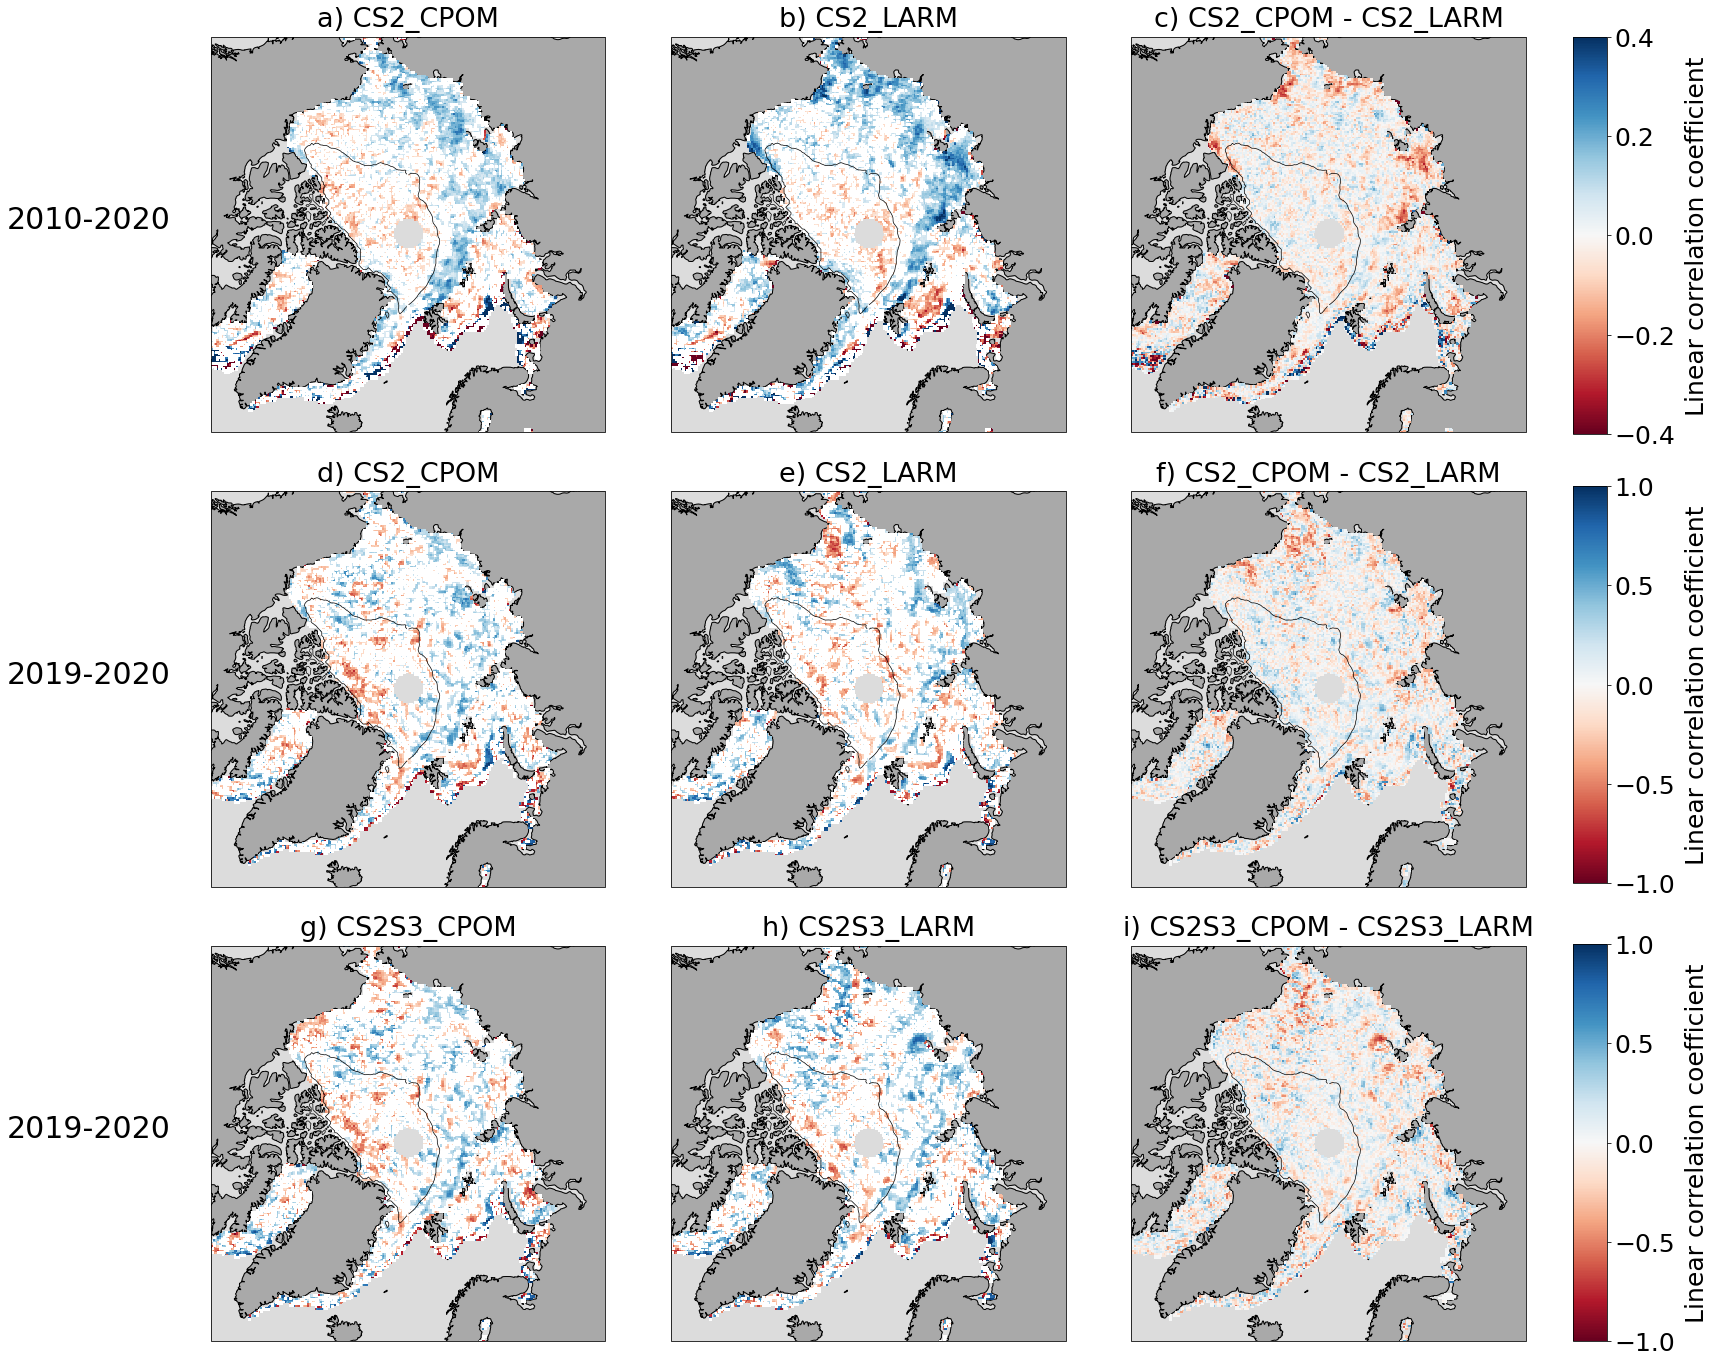

In [14]:
lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lat_25km.npy')
lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lon_25km.npy')

sats = ['CS2_CPOM_full','CS2_LARM_full','CS2_CPOM_full - CS2_LARM_full',
        'CS2_CPOM','CS2_LARM','CS2_CPOM - CS2_LARM',
        'CS2S3_CPOM','CS2S3_LARM','CS2S3_CPOM - CS2S3_LARM']
labels = ['CS2_CPOM','CS2_LARM','CS2_CPOM - CS2_LARM',
        'CS2_CPOM','CS2_LARM','CS2_CPOM - CS2_LARM',
        'CS2S3_CPOM','CS2S3_LARM','CS2S3_CPOM - CS2S3_LARM']
nums = ['a) ','b) ','c) ','d) ','e) ','f) ','g) ','h) ','i) ']

fig = plt.figure(figsize=(24,24))
spec = gridspec.GridSpec(ncols=3, nrows=3,hspace=0.15,wspace=0.1)

vmins = [-0.4, -0.4, -0.4, -1, -1, -1, -1, -1, -1]
vmaxs = [0.4, 0.4, 0.4, 1, 1, 1, 1, 1, 1]

for counter, ax in enumerate(sats):
    ax = fig.add_subplot(spec[counter],projection=ccrs.NorthPolarStereo())
    rs = all_rs[sats[counter]]
        
    if counter in [0,1,3,4,6,7]:
        ps = all_ps[sats[counter]]
        rs[ps>0.05] = 1000
        grey = rs.copy()
        grey[grey <1000] = np.nan
        rs[rs==1000] = np.nan

    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
    ax.coastlines()
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    p_map = ax.pcolormesh(lons,lats,rs,cmap='RdBu',vmin=vmins[counter],vmax=vmaxs[counter], transform=ccrs.PlateCarree())
    if counter in [0,1,3,4,6,7]:
        ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=1000,vmax=6000, transform=ccrs.PlateCarree())
    ax.set_title(nums[counter]+labels[counter],fontsize=27, pad=10)
    
    cont_less = ax.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=0.7)

    cont_Great = ax.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=0.7)
    
    if counter == 2: 
        cbar_ax = fig.add_axes([0.92, 0.65, 0.02, 0.23]) # x, y, width, height
        a = fig.colorbar(p_map, cax =cbar_ax)
        a.ax.tick_params(labelsize=25)
        a.set_label("Linear correlation coefficient", fontsize = 25, labelpad = 10)
    if counter == 5: 
        cbar_ax = fig.add_axes([0.92, 0.39, 0.02, 0.23])
        a = fig.colorbar(p_map, cax = cbar_ax)
        a.ax.tick_params(labelsize=25)
        a.set_label("Linear correlation coefficient", fontsize = 25, labelpad = 10)
    if counter == 8: 
        cbar_ax = fig.add_axes([0.92, 0.125, 0.02, 0.23])
        a = fig.colorbar(p_map, cax = cbar_ax)
        a.ax.tick_params(labelsize=25)
        a.set_label("Linear correlation coefficient", fontsize = 25, labelpad = 10)
    if counter == 0: 
        ax.annotate('2010-2020', xy = (-0.1,0.5), xycoords = 'axes fraction', va = 'bottom', ha = 'right', color = 'k', fontsize = 30)
    if counter == 3: 
        ax.annotate('2019-2020', xy = (-0.1,0.5), xycoords = 'axes fraction', va = 'bottom', ha = 'right',  color = 'k', fontsize = 30)
    if counter == 6: 
        ax.annotate('2019-2020', xy = (-0.1,0.5), xycoords = 'axes fraction', va = 'bottom', ha = 'right', color = 'k', fontsize = 30)

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/retrack_gridcells.png',bbox_inches = "tight")

In [12]:
for sat in sats:
    
    pos =  np.sum(all_rs[sat] > 0)
    neg =  np.sum(all_rs[sat] < 0)

    print(sat, ': pos = ', pos, 'neg = ', neg)

CS2_CPOM_full : pos =  6335 neg =  4024
CS2_LARM_full : pos =  7624 neg =  3593
CS2_CPOM_full - CS2_LARM_full : pos =  7737 neg =  9886
CS2_CPOM : pos =  4944 neg =  3869
CS2_LARM : pos =  4720 neg =  4170
CS2_CPOM - CS2_LARM : pos =  8305 neg =  8074
CS2S3_CPOM : pos =  4773 neg =  4178
CS2S3_LARM : pos =  5517 neg =  3543
CS2S3_CPOM - CS2S3_LARM : pos =  7950 neg =  8422


In [3]:
# positive CS2S3_LARM - positive CS2S3_CPOM
5517/4773

1.1558768070395977